# Experiment 2

In [1]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379496 sha256=03877ac5537a170f2646766a29a36007459e02b1a0d00b99881728e774725e91
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import copy
from itertools import count
import warnings
import os
import json
from google.colab import drive

warnings.filterwarnings("ignore")

drive.mount('/content/drive')
%cd "/content/drive/My Drive/ARL/exp2"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
/content/drive/My Drive/ARL/exp2


## Standard DQN

In [3]:
GAMMA = 0.99
BATCH_SIZE = 128
BUFFER_SIZE = 100000
MIN_REPLAY_SIZE = 10000
MAX_EPISODES = 750

TAU_VALUES = [0.001, 0.005, 0.01]
NOISE_STD_VALUES = [0.1, 0.2, 0.3]

In [4]:
# Create environment
env = gym.make("LunarLanderContinuous-v3")
obs, _ = env.reset()
episode_reward = 0.0

In [5]:
class ActionNoise(object):
    def reset(self):
        pass

class OrnsteinUhlenbeckActionNoise(ActionNoise):
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)


In [6]:
T = lambda x: torch.as_tensor(x, dtype=torch.float32)
Ti = lambda x: torch.as_tensor(x, dtype=torch.int64)

In [7]:
Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'dones', 'next_states'))


class Replay_memory():

    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize)
        self.rewards = deque(maxlen=50)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        self.memory.append(transition)

    def sample_batch(self):
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.states, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.actions, dtype=np.float32))
        rewards = torch.from_numpy(np.array(batch.rewards, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.dones, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_states, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        obs, _ = env.reset()
        for _ in range(self.minsize):
            action = self.env.action_space.sample()
            new_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            transition = Transition(obs, action, reward, done, new_obs)
            self.append(transition)
            obs = new_obs
            if done:
                self.env.reset()
        return self

In [8]:
replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

In [9]:
# Policy/Actor Network
class PolicyNet(nn.Module):

    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x) * self.pmax
        torch.clip_(x, self.pmin, self.pmax)
        return x

    def __call__(self, x):
        out = self.forward(x)
        return out


In [10]:
#Critic Network
class DQN(nn.Module):

    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.model(x)
        return x

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out


In [11]:
obs_size = env.observation_space.shape[0]
act_size = env.action_space.shape[0]
hiddenlayers = 256
output_minrange = env.action_space.low
output_maxrange = env.action_space.high

In [12]:

def train_with_parameters(tau, noise_std):
    # Initialize networks and optimizers
    actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))
    actor_target = copy.deepcopy(actor)
    critic = DQN(obs_size + act_size, hiddenlayers)
    critic_target = copy.deepcopy(critic)

    actor_optimizer = optim.AdamW(actor.parameters(), lr=0.0001)
    critic_optimizer = optim.AdamW(critic.parameters(), lr=0.001)

    # Initialize noise generator
    ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(2), sigma=float(noise_std) * np.ones(2))

    # Initialize replay memory
    replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

    returns = deque(maxlen=50)
    episode_rewards = []
    convergence_episode = float('inf')

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            with torch.no_grad():
                action = actor(T(state)).numpy() + ou_noise()
            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            transition = Transition(state, action, reward, done, new_state)
            replay_memory.append(transition)

            # Update networks
            states, actions, rewards, dones, next_states = replay_memory.sample_batch()

            ou_noise.reset()  # Reset noise before network updates

            # Critic loss
            Qvals = critic(states, actions)
            with torch.no_grad():
                actions_ = actor_target(next_states)
                Qvals_ = critic_target(next_states, actions_)
                Qvals_[dones] = 0.0
                target = rewards + GAMMA * Qvals_
            critic_loss = F.smooth_l1_loss(target, Qvals)

            # Actor loss
            actor_loss = -critic(states, actor(states)).mean()

            # Update networks
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update target networks with current tau value
            for target_param, param in zip(actor_target.parameters(), actor.parameters()):
                target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

            for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

            state = new_state
            episode_reward += reward

        returns.append(episode_reward)
        episode_rewards.append(episode_reward)
        score = np.mean(returns)

        print(f'Episode: {episode}  Return: {episode_reward}')

        if episode % 50 == 0:
            print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')

        if score >= 195 and convergence_episode == float('inf'):
            convergence_episode = episode
            print(f'Solved! Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
            break

    return episode_rewards, convergence_episode


In [13]:
# Run experiments and save results
results_file = 'ddpg_hyper_param_results.json'

# Initialize or load existing results
if os.path.exists(results_file):
    with open(results_file, 'r') as f:
        data = json.load(f)
        results = data['results']
        convergence_episodes = data['convergence_episodes']
    print(f"Loaded existing results from {results_file}")
else:
    results = {}
    convergence_episodes = {}

# Generate all possible combinations
all_combinations = [f"tau{tau}_noise{noise_std}"
                   for tau in TAU_VALUES
                   for noise_std in NOISE_STD_VALUES]

# Find missing combinations
missing_combinations = [combo for combo in all_combinations if combo not in results]

if not missing_combinations:
    print("All experiments have been completed!")
else:
    print(f"Running {len(missing_combinations)} remaining experiments...")

    for combo in missing_combinations:
        # Extract parameters from the combination string
        tau = float(combo.split('_')[0][3:])
        noise_std = float(combo.split('_')[1][5:])

        print(f"\nTraining with {combo}")
        rewards, conv_episode = train_with_parameters(tau, noise_std)

        # Update results and save after each run
        results[combo] = rewards
        convergence_episodes[combo] = conv_episode if conv_episode != float('inf') else MAX_EPISODES

        # Save current progress
        with open(results_file, 'w') as f:
            json.dump({
                'results': results,
                'convergence_episodes': convergence_episodes
            }, f)
        print(f"Updated results saved to {results_file}")

Loaded existing results from ddpg_hyper_param_results.json
All experiments have been completed!


In [14]:
# Analyze and plot results
# Sort combinations by convergence episode
sorted_combinations = sorted(convergence_episodes.items(), key=lambda x: x[1])

# Print sorted combinations
print("\nCombinations sorted by convergence speed:")
for combination, conv_episode in sorted_combinations:
    print(f"{combination}: {'Did not converge' if conv_episode == MAX_EPISODES else f'Converged at episode {conv_episode}'}")



Combinations sorted by convergence speed:
tau0.01_noise0.2: Converged at episode 100
tau0.01_noise0.3: Converged at episode 153
tau0.005_noise0.1: Converged at episode 186
tau0.001_noise0.3: Converged at episode 205
tau0.001_noise0.2: Converged at episode 214
tau0.01_noise0.1: Converged at episode 232
tau0.005_noise0.3: Converged at episode 288
tau0.001_noise0.1: Converged at episode 337
tau0.005_noise0.2: Converged at episode 403


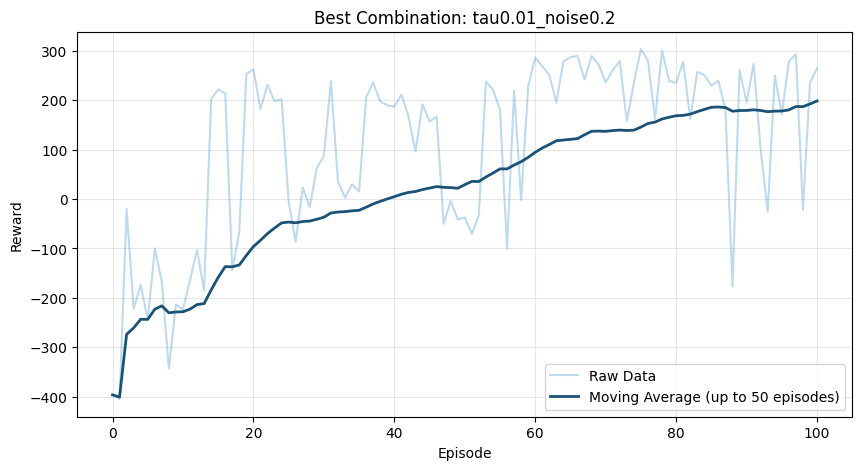

In [23]:
# Plot the best combination with moving average
best_key = sorted_combinations[0][0]
max_window = 50  # Maximum size of the moving average window

# Calculate variable window moving average
rewards = np.array(results[best_key])
moving_avg = []
for i in range(len(rewards)):
    # Use window size that grows up to max_window
    window = min(i + 1, max_window)
    start_idx = max(0, i + 1 - window)
    moving_avg.append(np.mean(rewards[start_idx:i + 1]))

# Convert to numpy array for plotting
moving_avg = np.array(moving_avg)

# Create x-axis values
x_raw = np.arange(len(rewards))

# Create the plot
plt.figure(figsize=(10, 5))

# Plot both raw data (light) and moving average (dark)
plt.plot(
    x_raw,
    rewards,
    alpha=0.3,
    color='#2E86C1',
    label='Raw Data'
)
plt.plot(
    x_raw,
    moving_avg,
    color='#1A5276',
    linewidth=2,
    label=f'Moving Average (up to {max_window} episodes)'
)

plt.title(f"Best Combination: {best_key}")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

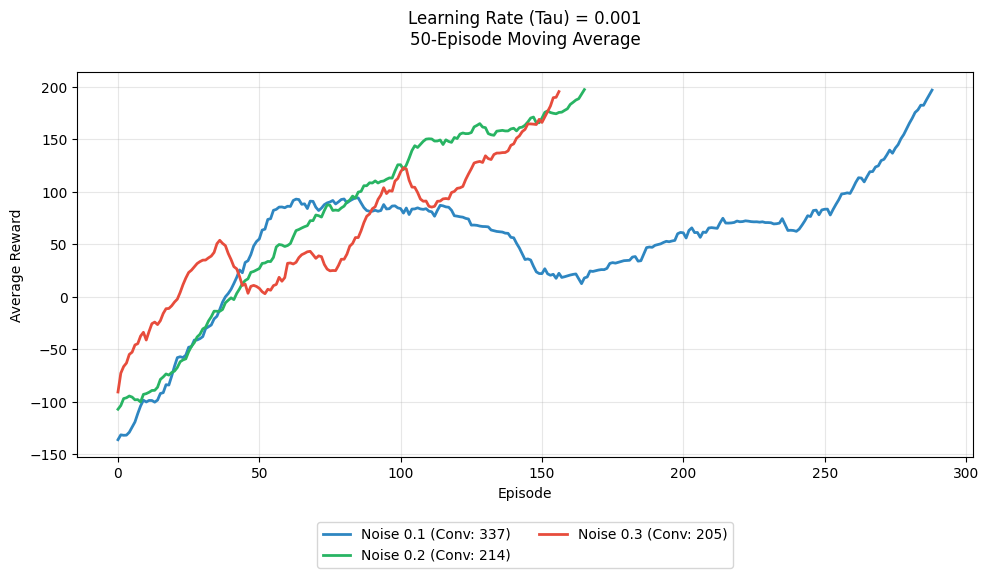

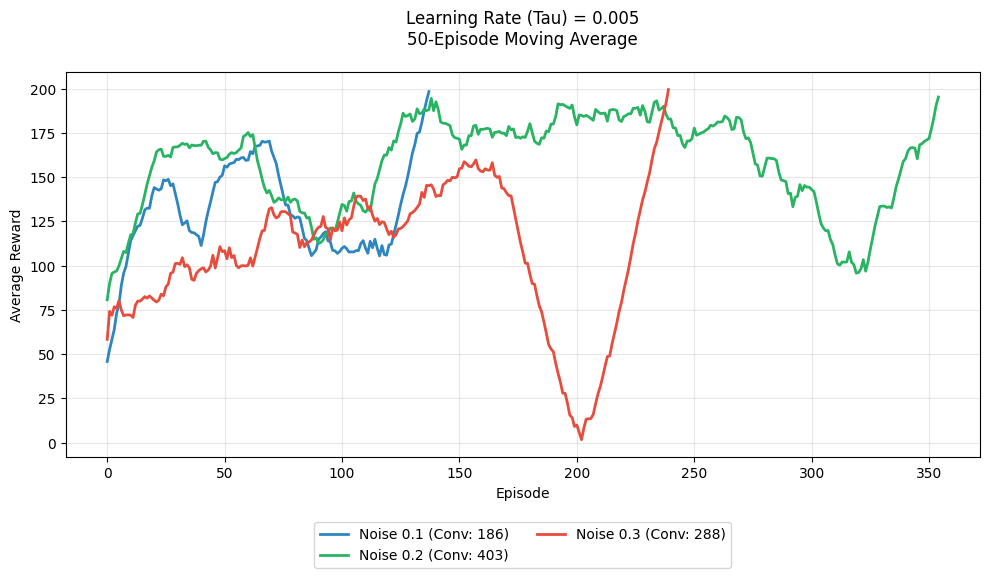

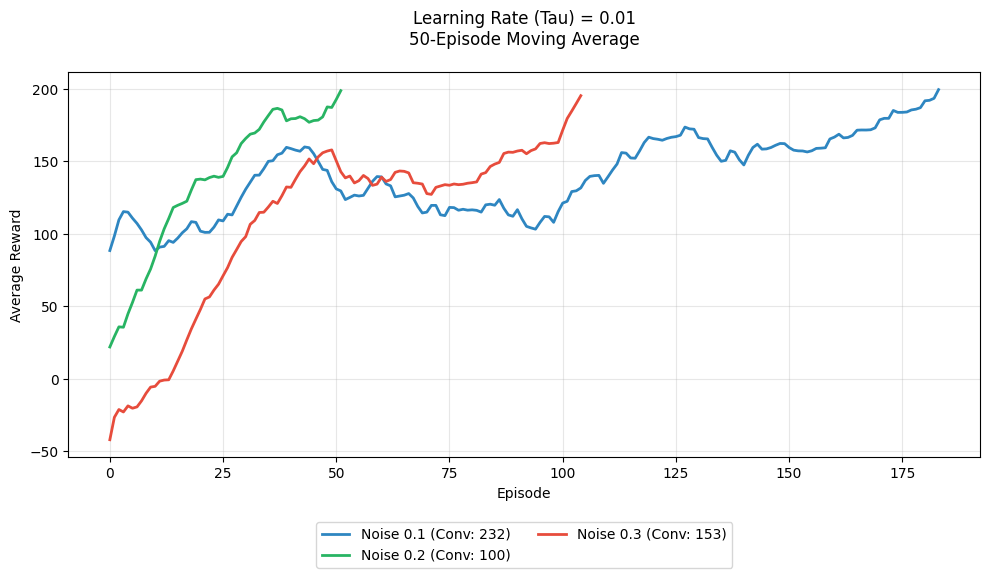

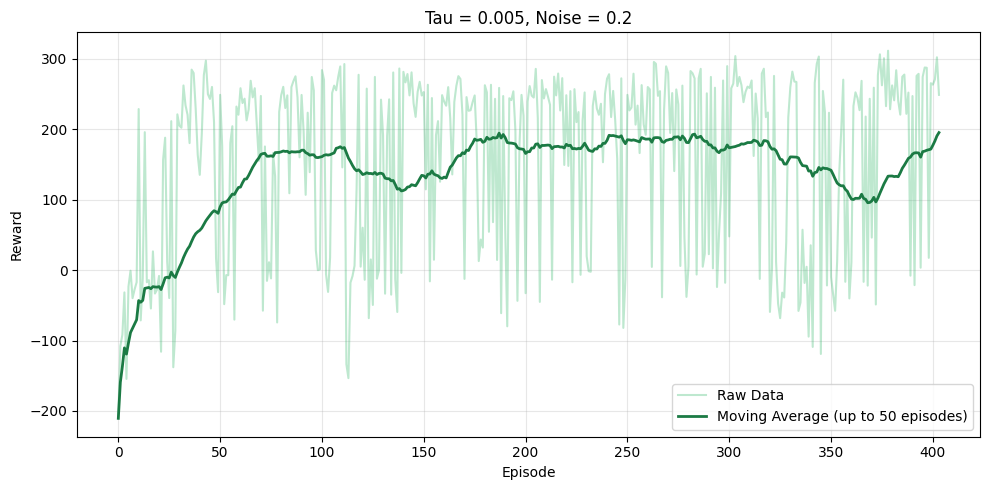

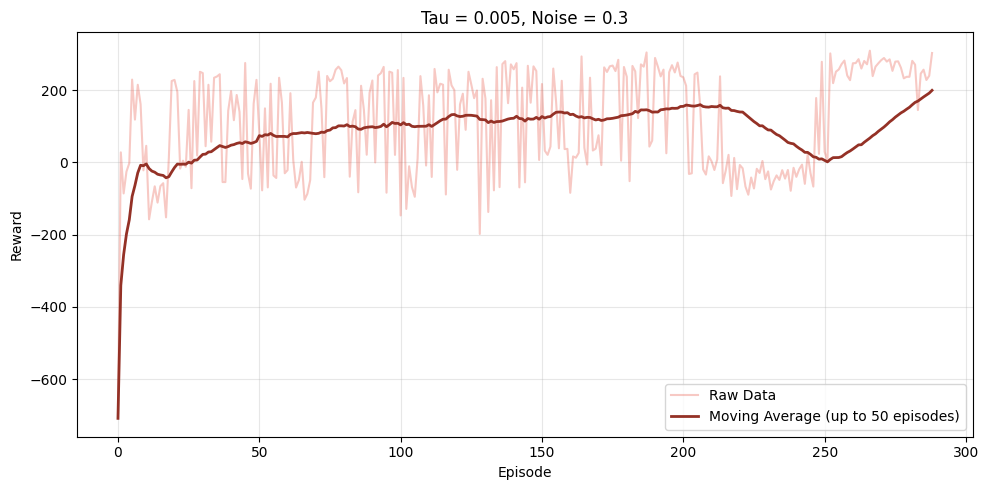

In [28]:
# Create individual plots for different tau values

colors = ["#2E86C1", "#28B463", "#E74C3C"]  # One color per noise value

# First create the three tau comparison plots
for i, tau in enumerate(TAU_VALUES):
    plt.figure(figsize=(10, 6))

    for j, noise_std in enumerate(NOISE_STD_VALUES):
        key = f"tau{tau}_noise{noise_std}"

        # Calculate moving average
        moving_avg = np.convolve(
            results[key],
            np.ones(window_size) / window_size,
            mode='valid'
        )

        # Plot moving average
        plt.plot(
            moving_avg,
            color=colors[j],
            linewidth=2,
            label=f"Noise {noise_std} (Conv: {convergence_episodes[key]})"
        )

    plt.title(f"Learning Rate (Tau) = {tau}\n{window_size}-Episode Moving Average", pad=20)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Create individual plots for tau=0.005 with noise=0.2 and 0.3
colors = {
    0.2: ('#28B463', '#1B7A44'),  # Light and dark green
    0.3: ('#E74C3C', '#943126')   # Light and dark red
}

for noise_std in [0.2, 0.3]:
    key = f"tau0.005_noise{noise_std}"
    rewards = np.array(results[key])

    # Calculate variable window moving average
    moving_avg = []
    for i in range(len(rewards)):
        window = min(i + 1, window_size)
        start_idx = max(0, i + 1 - window)
        moving_avg.append(np.mean(rewards[start_idx:i + 1]))

    moving_avg = np.array(moving_avg)
    x_raw = np.arange(len(rewards))

    # Create the plot
    plt.figure(figsize=(10, 5))

    # Plot raw data and moving average with corresponding colors
    plt.plot(
        x_raw,
        rewards,
        alpha=0.3,
        color=colors[noise_std][0],
        label='Raw Data'
    )
    plt.plot(
        x_raw,
        moving_avg,
        color=colors[noise_std][1],
        linewidth=2,
        label=f'Moving Average (up to {window_size} episodes)'
    )

    plt.title(f"Tau = 0.005, Noise = {noise_std}")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Noise

In [17]:
def inject_gaussian_noise(state, noise_value):
    if noise_value == "LOW":
        noise_level = 0.01
    elif noise_value == "MEDIUM":
        noise_level = 0.05
    elif noise_value == "HIGH":
        noise_level = 0.1
    else:
        return state  # Return original state for baseline

    if not isinstance(state, torch.Tensor):
        state = torch.tensor(state, dtype=torch.float32)

    noise = torch.randn(state.size()) * noise_level
    noisy_state = state + noise
    return noisy_state

In [18]:
def train_with_parameters_noisy(tau = 0.01, noise_std = 0.2, noise_level = None):
    # Initialize networks and optimizers
    actor = PolicyNet(obs_size, hiddenlayers, act_size, T(output_minrange), T(output_maxrange))
    actor_target = copy.deepcopy(actor)
    critic = DQN(obs_size + act_size, hiddenlayers)
    critic_target = copy.deepcopy(critic)

    actor_optimizer = optim.AdamW(actor.parameters(), lr=0.0001)
    critic_optimizer = optim.AdamW(critic.parameters(), lr=0.001)

    # Initialize noise generator
    ou_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(2), sigma=float(noise_std) * np.ones(2))

    # Initialize replay memory
    replay_memory = Replay_memory(env, BUFFER_SIZE, MIN_REPLAY_SIZE, BATCH_SIZE).initialize()

    returns = deque(maxlen=50)
    episode_rewards = []
    convergence_episode = float('inf')

    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            if noise_level is not None:
                state = inject_gaussian_noise(state, noise_level)

            with torch.no_grad():
                action = actor(T(state)).numpy() + ou_noise()
            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            transition = Transition(state, action, reward, done, new_state)
            replay_memory.append(transition)

            # Update networks
            states, actions, rewards, dones, next_states = replay_memory.sample_batch()

            ou_noise.reset()  # Reset noise before network updates

            # Critic loss
            Qvals = critic(states, actions)
            with torch.no_grad():
                actions_ = actor_target(next_states)
                Qvals_ = critic_target(next_states, actions_)
                Qvals_[dones] = 0.0
                target = rewards + GAMMA * Qvals_
            critic_loss = F.smooth_l1_loss(target, Qvals)

            # Actor loss
            actor_loss = -critic(states, actor(states)).mean()

            # Update networks
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update target networks with current tau value
            for target_param, param in zip(actor_target.parameters(), actor.parameters()):
                target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

            for target_param, param in zip(critic_target.parameters(), critic.parameters()):
                target_param.data.copy_(param.data * tau + target_param.data * (1.0 - tau))

            state = new_state
            episode_reward += reward

        returns.append(episode_reward)
        episode_rewards.append(episode_reward)
        score = np.mean(returns)

        print(f'Episode: {episode}  Return: {episode_reward}')

        if episode % 50 == 0:
            print(f'Episode: {episode}  Return: {episode_reward}  Average Return: {score}')

        if score >= 195 and convergence_episode == float('inf'):
            convergence_episode = episode
            print(f'Solved! Episode: {episode}  Return: {episode_reward}  Average Return: {score}')
            break

    return episode_rewards, convergence_episode


In [19]:
noise_file = 'noise_results.json'
noise_levels = ["LOW", "MEDIUM", "HIGH"]

# Check if noise results file exists
if os.path.exists(noise_file):
    # Load existing results
    with open(noise_file, 'r') as f:
        data = json.load(f)
        noise_results = data['noise_results']
        noise_convergence = data['noise_convergence']
    print(f"Loaded existing noise results from {noise_file}")
else:
    # Run the noise experiments
    noise_results = {}
    noise_convergence = {}

# add baseline after 1st runs r done

    # Run with different noise levels
    for noise_level in noise_levels:
        print(f"\nTraining DDPG DQN with {noise_level} noise")
        rewards, conv_episode = train_with_parameters_noisy(
            noise_level=noise_level
        )
        noise_results[f"{noise_level}"] = rewards
        noise_convergence[f"{noise_level}"] = conv_episode

    # Convert NumPy arrays to lists before saving
    results_to_save = {k: v.tolist() if hasattr(v, 'tolist') else v for k, v in noise_results.items()}
    convergence_to_save = {k: v.tolist() if hasattr(v, 'tolist') else v for k, v in noise_convergence.items()}

    # Save results to JSON
    with open(noise_file, 'w') as f:
        json.dump({
            'noise_results': results_to_save,
            'noise_convergence': convergence_to_save
        }, f)
    print(f"Saved noise results to {noise_file}")

Loaded existing noise results from noise_results.json


In [20]:
# Print convergence results
print("\nConvergence Results (sorted by episode):")
sorted_results = sorted(noise_convergence.items(), key=lambda x: x[1])
for model, episode in sorted_results:
    print(
        f"{model}: {'Did not converge' if episode == 750 else f'Converged at episode {episode}'}"
    )


Convergence Results (sorted by episode):
LOW: Converged at episode 226
MEDIUM: Converged at episode inf
HIGH: Converged at episode inf


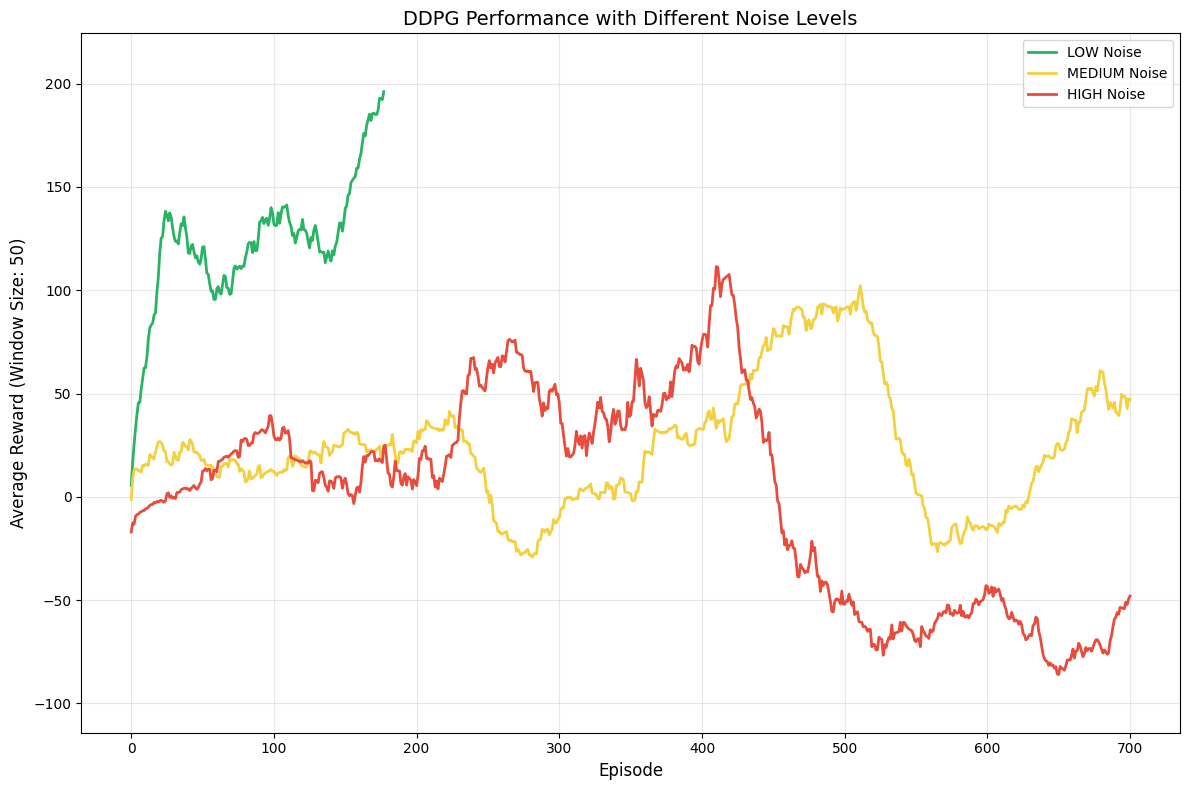

In [21]:
# Plot noise comparison
plt.figure(figsize=(12, 8))
window_size = 50

colors = {
    "baseline": "#2E86C1",  # Blue
    "LOW": "#28B463",  # Green
    "MEDIUM": "#F4D03F",  # Yellow
    "HIGH": "#E74C3C",  # Red
}

# Load results
with open(noise_file, 'r') as f:
    data = json.load(f)
    noise_results = data['noise_results']

# Plot each noise level
for noise_level, rewards in noise_results.items():
    # Calculate moving average
    moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    episodes = range(len(moving_avg))

    # Plot with corresponding color
    plt.plot(episodes, moving_avg,
            label=f'{noise_level} Noise',
            color=colors[noise_level],
            linewidth=2)

plt.xlabel('Episode', fontsize=12)
plt.ylabel(f'Average Reward (Window Size: {window_size})', fontsize=12)
plt.title('DDPG Performance with Different Noise Levels', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.margins(y=0.1)
plt.tight_layout()
plt.show()